## Deep learning

In [1]:
import h2o
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

Define all the starter functions

In [2]:
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
        iv = pd.read_csv(i,header=None)
    except:
        sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
        ivd[c.strip()]=dt[i].strip()
        i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
            if dct[key] not in ['real','int','enum']:                      
                targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
            if dct[key] != val:
                print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                    df[key] = df[key].asfactor() 
                except:
                    targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                    df[key] = df[key].asnumeric() 
                except:
                    targ.remove(key)                  
            if dct[key]=='real':
                try:                
                    df[key] = df[key].asnumeric()  
                except:
                    targ.remove(key)                  
    if y is None:
        y=df.columns[-1] 
    if y in targ:
        targ.remove(y)
    else:
        y=targ.pop()            
    return targ

def check_X(x,df):
    for name in x:
        if name not in df.columns:
            x.remove(name)  
    return x 

Initialize H2O

In [3]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=6,port=port_no)

Checking whether there is an H2O instance running at http://localhost:13546..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\raksh\AppData\Local\Temp\tmp47f68vfy
  JVM stdout: C:\Users\raksh\AppData\Local\Temp\tmp47f68vfy\h2o_raksha_started_from_python.out
  JVM stderr: C:\Users\raksh\AppData\Local\Temp\tmp47f68vfy\h2o_raksha_started_from_python.err
  Server is running at http://127.0.0.1:13546
Connecting to H2O server at http://127.0.0.1:13546... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_raksha_v7s9m1
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Import data

In [4]:
df = h2o.import_file("car_clean.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
all_variables=None
scale=False

In [6]:
df.describe()

Rows:1727
Cols:8




,C1,buying,maint,doors,persons,lug_boot,safety,class
type,int,enum,enum,int,int,enum,enum,enum
mins,0.0,,,2.0,2.0,,,
mean,863.0,,,3.0007722007722,3.0008688097306666,,,
maxs,1726.0,,,4.0,4.0,,,
sigma,498.6862741243236,,,0.8166539469613198,1.0004343105525066,,,
zeros,1,,,0,0,,,
missing,0,0,0,432,576,0,0,0
0,0.0,vhigh,vhigh,2.0,2.0,small,med,unacc
1,1.0,vhigh,vhigh,2.0,2.0,small,high,unacc
2,2.0,vhigh,vhigh,2.0,2.0,med,low,unacc


Define Target variables

In [7]:
y = "class"

In [8]:
df[y] = df[y].asfactor()

In [9]:
if all_variables is not None:
    ivd=get_all_variables_csv(all_variables)
    print(ivd)    
    X=check_all_variables(df,ivd,y)
    print(X)

In [10]:
X = []  
if all_variables is None:
    X=get_independent_variables(df, y)  
else: 
    ivd=get_all_variables_csv(all_variables)    
    X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

#meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

Split the dataset and run the model for train and test

In [11]:
train, test = df.split_frame([0.9])

In [13]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
dl = H2ODeepLearningEstimator()
dl.train(x=X, y = y, training_frame=train, validation_frame=test)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


### Plots and Metrics

In [15]:
dl.confusion_matrix

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1539717738893_2


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.035072867649807146
RMSE: 0.18727751506736506
LogLoss: 0.11898740299811555
Mean Per-Class Error: 0.05583076014160632
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
279.0,5.0,58.0,0.0,0.1842105,63 / 342
0.0,62.0,0.0,1.0,0.0158730,1 / 63
8.0,0.0,1078.0,0.0,0.0073665,"8 / 1,086"
0.0,1.0,0.0,62.0,0.0158730,1 / 63
287.0,68.0,1136.0,63.0,0.0469755,"73 / 1,554"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9530245
2,1.0
3,1.0
4,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.04481416528338164
RMSE: 0.21169356457715394
LogLoss: 0.16062525863806038
Mean Per-Class Error: 0.17073170731707316
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
35.0,0.0,5.0,2.0,0.1666667,7 / 42
0.0,6.0,0.0,0.0,0.0,0 / 6
2.0,0.0,121.0,0.0,0.0162602,2 / 123
0.0,1.0,0.0,1.0,0.5,1 / 2
37.0,7.0,126.0,3.0,0.0578035,10 / 173


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9421966
2,1.0
3,1.0
4,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
,2018-10-16 15:24:36,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2018-10-16 15:24:37,1.757 sec,1475 obs/sec,1.0,1,1554.0,0.4550346,1.0364122,0.7302737,0.2445302,0.4374787,1.0853457,0.7477079,0.2254335
,2018-10-16 15:24:42,6.756 sec,2360 obs/sec,9.0,9,13986.0,0.2199219,0.1644180,0.9369955,0.0649936,0.2239029,0.1693611,0.9339141,0.0635838
,2018-10-16 15:24:43,7.475 sec,2366 obs/sec,10.0,10,15540.0,0.1872775,0.1189874,0.9543116,0.0469755,0.2116936,0.1606253,0.9409248,0.0578035


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
safety.low,1.0,1.0,0.0755247
safety.high,0.9026052,0.9026052,0.0681690
maint.vhigh,0.8335341,0.8335341,0.0629524
lug_boot.small,0.8307771,0.8307771,0.0627442
persons,0.8055347,0.8055347,0.0608378
---,---,---,---
doors,0.6344479,0.6344479,0.0479165
buying.missing(NA),0.0,0.0,0.0
maint.missing(NA),0.0,0.0,0.0
lug_boot.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


<bound method H2OMultinomialModel.confusion_matrix of >

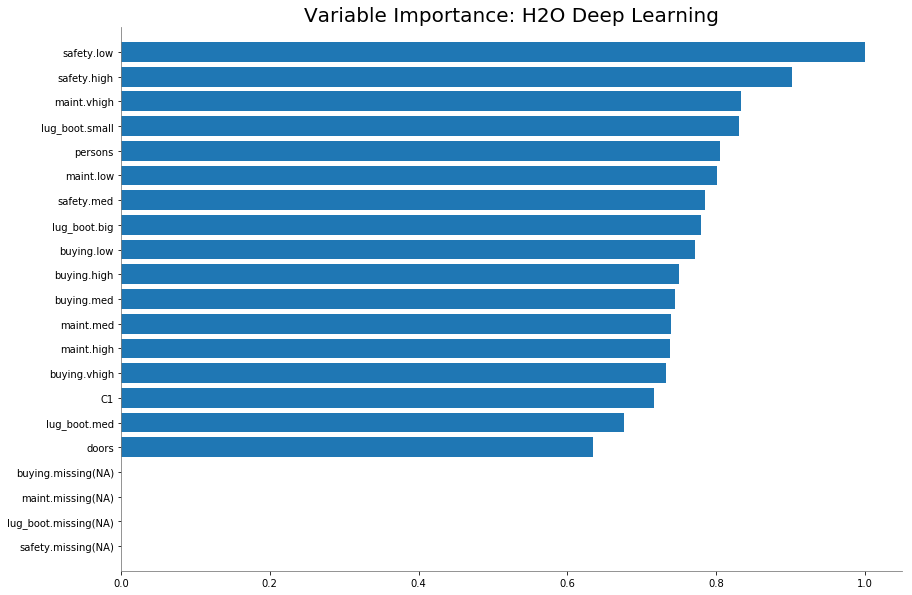

In [18]:
dl.varimp_plot(num_of_features=33)

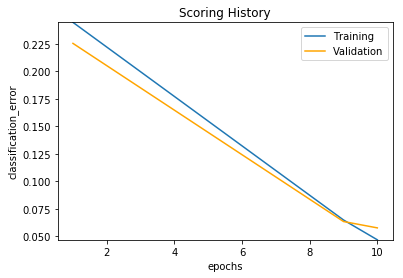

In [19]:
dl.plot()

In [22]:
dl.model_performance()


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.035072867649807146
RMSE: 0.18727751506736506
LogLoss: 0.11898740299811555
Mean Per-Class Error: 0.05583076014160632
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
279.0,5.0,58.0,0.0,0.1842105,63 / 342
0.0,62.0,0.0,1.0,0.0158730,1 / 63
8.0,0.0,1078.0,0.0,0.0073665,"8 / 1,086"
0.0,1.0,0.0,62.0,0.0158730,1 / 63
287.0,68.0,1136.0,63.0,0.0469755,"73 / 1,554"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9530245
2,1.0
3,1.0
4,1.0
